In [1]:
# =============================================================================
# Title   : Fuzzy Logic Portfolio — Robotics & Autonomous Systems (3 Examples)
# Course  : Models and Methods of Intelligent Systems
# Topic   : Obstacle Avoidance, Navigation Speed, Steering Assist (Mamdani FIS)
# Author  : Dr.-Ing. Cesar Hernando Valencia Niño
# Date    : 2026-01-27
# =============================================================================

# =========================
# Install & Imports
# =========================
!pip -q install scikit-fuzzy ipywidgets
import numpy as np, matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from ipywidgets import interact, FloatSlider, HTML
from IPython.display import display
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except Exception:
    pass
print("Setup complete.")

# =========================
# Helper Utilities
# =========================
def plot_mfs(variable, title_suffix=""):
    plt.figure()
    for term_name, term_obj in variable.terms.items():
        plt.plot(variable.universe, term_obj.mf, label=term_name)
    plt.title(f"Membership Functions — {variable.label} {title_suffix}".strip())
    plt.xlabel(variable.label); plt.ylabel("Membership degree")
    plt.ylim(-0.05, 1.05); plt.grid(True, alpha=0.3); plt.legend(); plt.show()

def report_system(title, antecedents, consequents, rules):
    print("\n" + "="*80); print(title); print("="*80)
    def _describe(v):
        u = v.universe
        print(f"\nVariable: {v.label}")
        print(f"  Universe: [{float(u.min()):.4f}, {float(u.max()):.4f}] | Points: {len(u)}")
        print("  Fuzzy sets (terms):")
        for t in v.terms.keys(): print(f"    - {t}")
    print("\n--- Antecedents (Inputs) ---")
    for a in antecedents: _describe(a)
    print("\n--- Consequents (Outputs) ---")
    for c in consequents: _describe(c)
    print("\n--- Rule Base ---")
    for i, r in enumerate(rules, 1): print(f"{i:02d}. {str(r)}")

def build_dashboard(system, inputs_spec, output_name, title):
    sim = ctrl.ControlSystemSimulation(system)
    sliders = {name: FloatSlider(value=v0, min=vmin, max=vmax, step=step,
                                 description=name, continuous_update=False)
               for (name, vmin, vmax, step, v0) in inputs_spec}
    display(HTML(f"<h3 style='margin:6px 0'>{title}</h3>"))
    def _run(**kwargs):
        for k, v in kwargs.items(): sim.input[k] = float(v)
        sim.compute()
        y = float(sim.output[output_name])
        print(f"{output_name} (defuzzified) = {y:.6f}")
        return y
    interact(_run, **sliders)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.9 MB/s eta 0:00:00
Setup complete.



Example 1 — Obstacle Avoidance (distance, angle → turn)

--- Antecedents (Inputs) ---

Variable: distance
  Universe: [0.0000, 1.0000] | Points: 201
  Fuzzy sets (terms):
    - close
    - far

Variable: angle
  Universe: [-1.0000, 1.0000] | Points: 201
  Fuzzy sets (terms):
    - left
    - center
    - right

--- Consequents (Outputs) ---

Variable: turn
  Universe: [-1.0000, 1.0000] | Points: 201
  Fuzzy sets (terms):
    - left
    - straight
    - right

--- Rule Base ---
01. IF distance[far] AND angle[center] THEN turn[straight]
	AND aggregation function : fmin
	OR aggregation function  : fmax
02. IF distance[far] AND angle[left] THEN turn[left]
	AND aggregation function : fmin
	OR aggregation function  : fmax
03. IF distance[far] AND angle[right] THEN turn[right]
	AND aggregation function : fmin
	OR aggregation function  : fmax
04. IF distance[close] AND angle[left] THEN turn[right]
	AND aggregation function : fmin
	OR aggregation function  : fmax
05. IF distance[close] AND ang

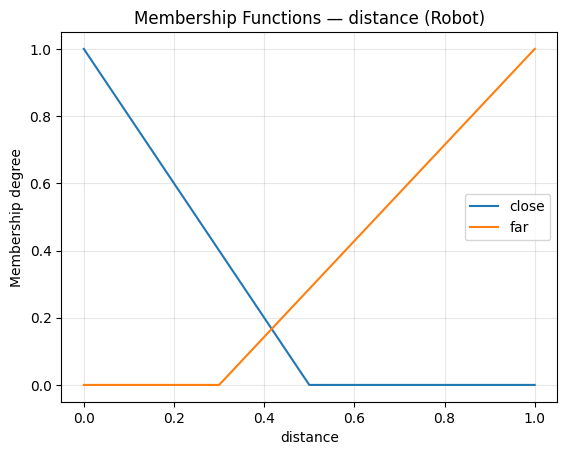

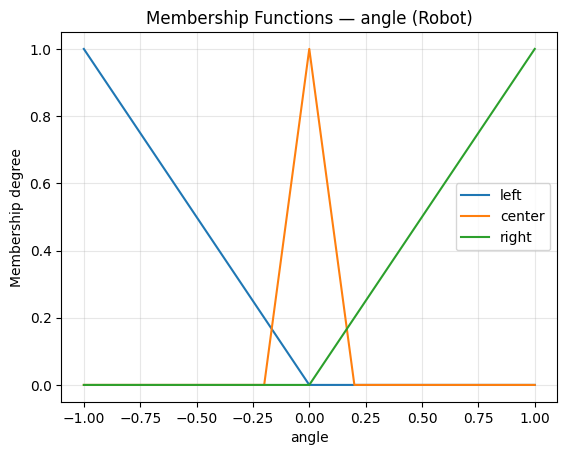

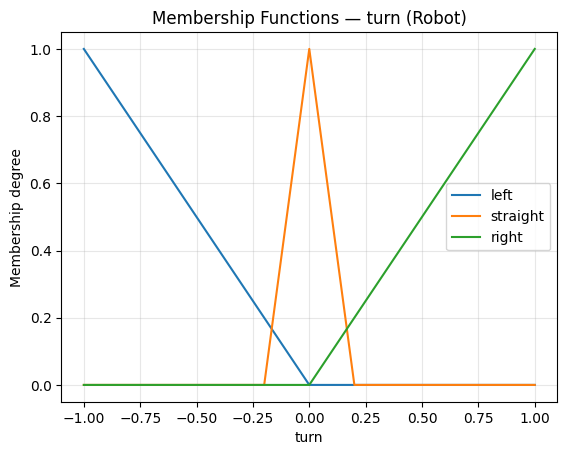

HTML(value="<h3 style='margin:6px 0'>Example 1 — Obstacle Avoidance Dashboard</h3>")

interactive(children=(FloatSlider(value=0.3, continuous_update=False, description='distance', max=1.0, step=0.…

In [2]:
# Example 1 — Obstacle Avoidance
distance = ctrl.Antecedent(np.linspace(0, 1, 201), 'distance')  # 0 close, 1 far
angle = ctrl.Antecedent(np.linspace(-1, 1, 201), 'angle')       # -1 left, +1 right
turn = ctrl.Consequent(np.linspace(-1, 1, 201), 'turn')

distance['close'] = fuzz.trimf(distance.universe, [0, 0, 0.5])
distance['far'] = fuzz.trimf(distance.universe, [0.3, 1, 1])

angle['left'] = fuzz.trimf(angle.universe, [-1, -1, 0])
angle['center'] = fuzz.trimf(angle.universe, [-0.2, 0, 0.2])
angle['right'] = fuzz.trimf(angle.universe, [0, 1, 1])

turn['left'] = fuzz.trimf(turn.universe, [-1, -1, 0])
turn['straight'] = fuzz.trimf(turn.universe, [-0.2, 0, 0.2])
turn['right'] = fuzz.trimf(turn.universe, [0, 1, 1])

rules = [
    ctrl.Rule(distance['far'] & angle['center'], turn['straight']),
    ctrl.Rule(distance['far'] & angle['left'], turn['left']),
    ctrl.Rule(distance['far'] & angle['right'], turn['right']),
    ctrl.Rule(distance['close'] & angle['left'], turn['right']),
    ctrl.Rule(distance['close'] & angle['right'], turn['left']),
    ctrl.Rule(distance['close'] & angle['center'], turn['left']),
]
system = ctrl.ControlSystem(rules)
report_system("Example 1 — Obstacle Avoidance (distance, angle → turn)", [distance, angle], [turn], rules)
plot_mfs(distance, "(Robot)"); plot_mfs(angle, "(Robot)"); plot_mfs(turn, "(Robot)")
build_dashboard(system, [('distance', 0, 1, 0.01, 0.3), ('angle', -1, 1, 0.01, 0.2)],
                'turn', "Example 1 — Obstacle Avoidance Dashboard")


Example 2 — Navigation Speed (goal_dist, nav_risk → speed)

--- Antecedents (Inputs) ---

Variable: goal_dist
  Universe: [0.0000, 1.0000] | Points: 201
  Fuzzy sets (terms):
    - near
    - far

Variable: nav_risk
  Universe: [0.0000, 1.0000] | Points: 201
  Fuzzy sets (terms):
    - low
    - high

--- Consequents (Outputs) ---

Variable: speed
  Universe: [0.0000, 1.0000] | Points: 201
  Fuzzy sets (terms):
    - slow
    - mid
    - fast

--- Rule Base ---
01. IF goal_dist[near] THEN speed[slow]
	AND aggregation function : fmin
	OR aggregation function  : fmax
02. IF goal_dist[far] AND nav_risk[low] THEN speed[fast]
	AND aggregation function : fmin
	OR aggregation function  : fmax
03. IF goal_dist[far] AND nav_risk[high] THEN speed[mid]
	AND aggregation function : fmin
	OR aggregation function  : fmax


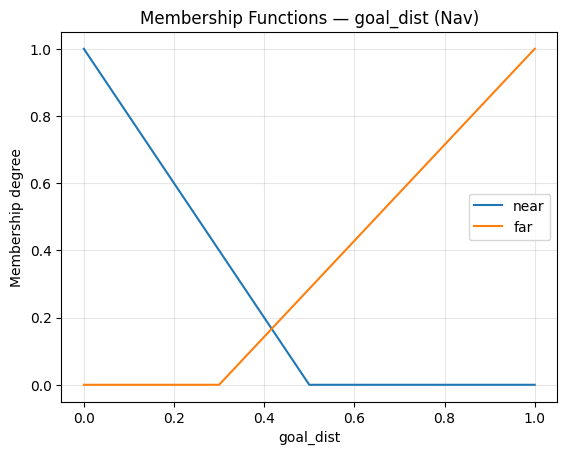

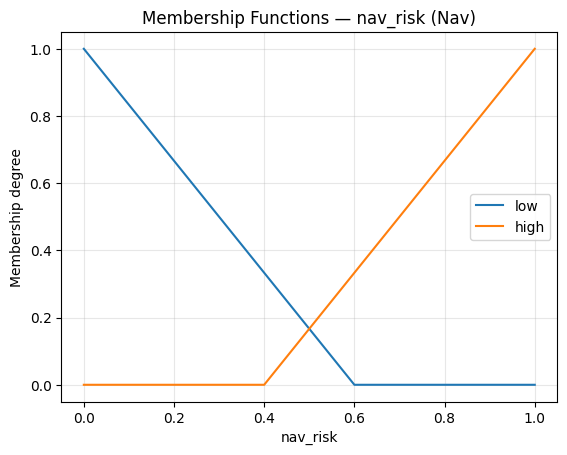

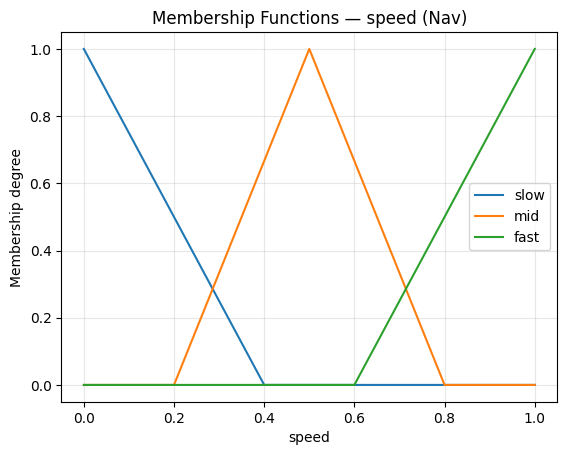

HTML(value="<h3 style='margin:6px 0'>Example 2 — Navigation Speed Dashboard</h3>")

interactive(children=(FloatSlider(value=0.8, continuous_update=False, description='goal_dist', max=1.0, step=0…

In [3]:
# Example 2 — Navigation Speed
goal_dist = ctrl.Antecedent(np.linspace(0, 1, 201), 'goal_dist') # 0 near, 1 far
nav_risk = ctrl.Antecedent(np.linspace(0, 1, 201), 'nav_risk')   # 0 safe, 1 risky
speed = ctrl.Consequent(np.linspace(0, 1, 201), 'speed')

goal_dist['near'] = fuzz.trimf(goal_dist.universe, [0, 0, 0.5])
goal_dist['far'] = fuzz.trimf(goal_dist.universe, [0.3, 1, 1])

nav_risk['low'] = fuzz.trimf(nav_risk.universe, [0, 0, 0.6])
nav_risk['high'] = fuzz.trimf(nav_risk.universe, [0.4, 1, 1])

speed['slow'] = fuzz.trimf(speed.universe, [0, 0, 0.4])
speed['mid'] = fuzz.trimf(speed.universe, [0.2, 0.5, 0.8])
speed['fast'] = fuzz.trimf(speed.universe, [0.6, 1, 1])

rules = [
    ctrl.Rule(goal_dist['near'], speed['slow']),
    ctrl.Rule(goal_dist['far'] & nav_risk['low'], speed['fast']),
    ctrl.Rule(goal_dist['far'] & nav_risk['high'], speed['mid']),
]
system = ctrl.ControlSystem(rules)
report_system("Example 2 — Navigation Speed (goal_dist, nav_risk → speed)", [goal_dist, nav_risk], [speed], rules)
plot_mfs(goal_dist, "(Nav)"); plot_mfs(nav_risk, "(Nav)"); plot_mfs(speed, "(Nav)")
build_dashboard(system, [('goal_dist', 0, 1, 0.01, 0.8), ('nav_risk', 0, 1, 0.01, 0.3)],
                'speed', "Example 2 — Navigation Speed Dashboard")


Example 3 — Steering Assist (lane_offset, curvature → steer)

--- Antecedents (Inputs) ---

Variable: lane_offset
  Universe: [-1.0000, 1.0000] | Points: 201
  Fuzzy sets (terms):
    - left
    - center
    - right

Variable: curvature
  Universe: [0.0000, 1.0000] | Points: 201
  Fuzzy sets (terms):
    - low
    - high

--- Consequents (Outputs) ---

Variable: steer
  Universe: [-1.0000, 1.0000] | Points: 201
  Fuzzy sets (terms):
    - left
    - straight
    - right

--- Rule Base ---
01. IF lane_offset[center] AND curvature[low] THEN steer[straight]
	AND aggregation function : fmin
	OR aggregation function  : fmax
02. IF lane_offset[left] THEN steer[right]
	AND aggregation function : fmin
	OR aggregation function  : fmax
03. IF lane_offset[right] THEN steer[left]
	AND aggregation function : fmin
	OR aggregation function  : fmax
04. IF lane_offset[center] AND curvature[high] THEN steer[left]
	AND aggregation function : fmin
	OR aggregation function  : fmax


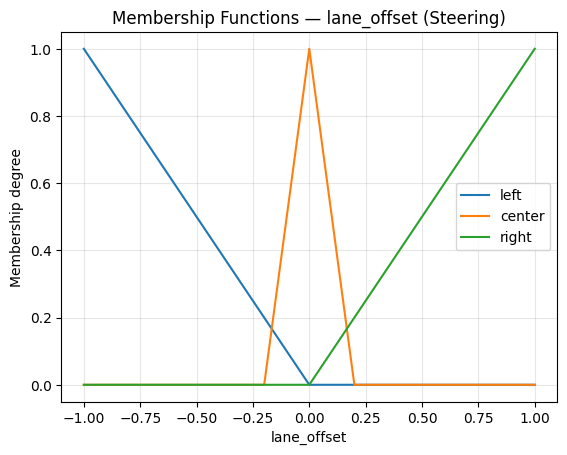

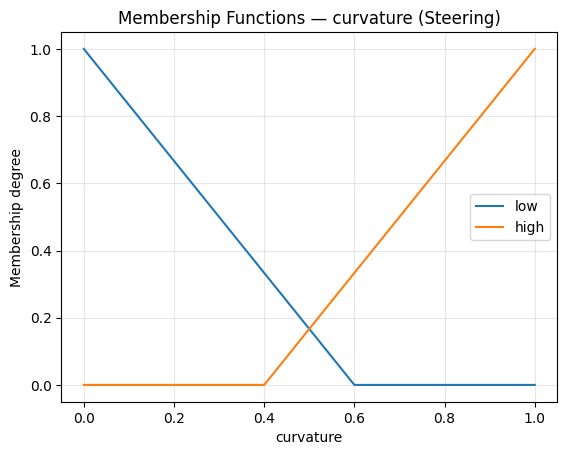

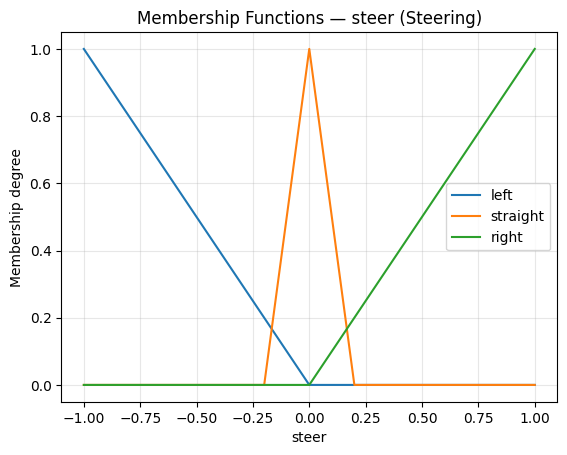

HTML(value="<h3 style='margin:6px 0'>Example 3 — Steering Assist Dashboard</h3>")

interactive(children=(FloatSlider(value=0.15, continuous_update=False, description='lane_offset', max=1.0, min…

In [4]:
# Example 3 — Steering Assist
lane_offset = ctrl.Antecedent(np.linspace(-1, 1, 201), 'lane_offset')
curvature = ctrl.Antecedent(np.linspace(0, 1, 201), 'curvature')
steer = ctrl.Consequent(np.linspace(-1, 1, 201), 'steer')

lane_offset['left'] = fuzz.trimf(lane_offset.universe, [-1, -1, 0])
lane_offset['center'] = fuzz.trimf(lane_offset.universe, [-0.2, 0, 0.2])
lane_offset['right'] = fuzz.trimf(lane_offset.universe, [0, 1, 1])

curvature['low'] = fuzz.trimf(curvature.universe, [0, 0, 0.6])
curvature['high'] = fuzz.trimf(curvature.universe, [0.4, 1, 1])

steer['left'] = fuzz.trimf(steer.universe, [-1, -1, 0])
steer['straight'] = fuzz.trimf(steer.universe, [-0.2, 0, 0.2])
steer['right'] = fuzz.trimf(steer.universe, [0, 1, 1])

rules = [
    ctrl.Rule(lane_offset['center'] & curvature['low'], steer['straight']),
    ctrl.Rule(lane_offset['left'], steer['right']),
    ctrl.Rule(lane_offset['right'], steer['left']),
    ctrl.Rule(lane_offset['center'] & curvature['high'], steer['left']),
]
system = ctrl.ControlSystem(rules)
report_system("Example 3 — Steering Assist (lane_offset, curvature → steer)", [lane_offset, curvature], [steer], rules)
plot_mfs(lane_offset, "(Steering)"); plot_mfs(curvature, "(Steering)"); plot_mfs(steer, "(Steering)")
build_dashboard(system, [('lane_offset', -1, 1, 0.01, 0.15), ('curvature', 0, 1, 0.01, 0.2)],
                'steer', "Example 3 — Steering Assist Dashboard")